In [1]:
#hide
import sys

if 'google.colab' in sys.modules:
    ! [ -e /content ] && pip install -Uqq fastbook

import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *

## Your First Model

Creating an dogs and cats image classifier

In [3]:
from fastai.vision.all import *

path = untar_data(URLs.PETS)/'images'

In [4]:
# Create a function to know whether the image is a cat or not
def is_cat(x): return x[0].isupper()

# Create a data loader
dls = ImageDataLoaders.from_name_func(path,get_image_files(path),is_cat,seed=42,
                                               item_tfms=Resize(224))

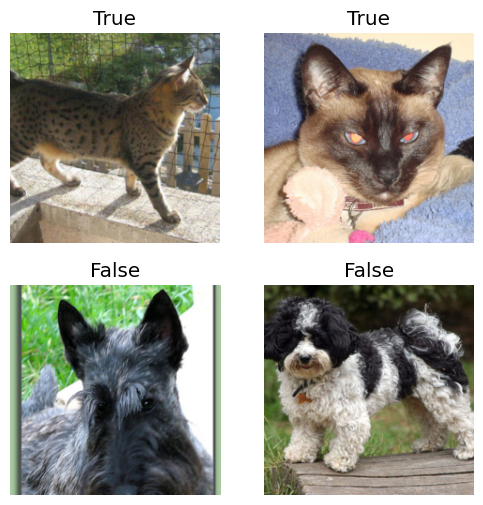

In [5]:
dls.show_batch(max_n=4)

In [6]:
# Create and train a learner
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

C:\Users\alexb\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\alexb\Anaconda3\envs\fastai\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.138252,0.022687,0.007442,00:59


epoch,train_loss,valid_loss,error_rate,time
0,0.060481,0.027023,0.010825,01:11
1,0.038781,0.022504,0.006766,01:12
2,0.014123,0.019851,0.006089,01:13


We will now test with a new image by uploading the image with a Jupyter Notebook widget

In [7]:
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [8]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['../images/dogtest.jpg'])

In [9]:
# Create a PIL image and run it through the model
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a cat?: {is_cat}.")
print(f"Probability it's a cat: {probs[1].item():.6f}")

Is this a cat?: False.
Probability it's a cat: 0.000012


## A Bit of Deep Learning Jargon

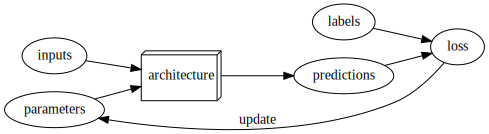

In [10]:
gv('''ordering=in
model[shape=box3d width=1 height=0.7 label=architecture]
inputs->model->predictions; parameters->model; labels->loss; predictions->loss
loss->parameters[constraint=false label=update]''')

### How Our Image Recognizer Works

- `from fastai.vision.all import *`: import all required components
- `path = untar_data(URLs.PETS)/'images'`: extract standard dataset
- `def is_cat(x): return x[0].isupper()`: Define the function that which of the images have cats and which ones have dogs. This is based on the structure set by the dataset authors.
- `dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path),is_cat,
    seed=42,item_tfms=Resize(224))`: data loader to load into the CNN
- `learn = vision_learner(dls, resnet34, metrics=error_rate)`: define the CNN model
- `learn.fine_tune(3)`: fine tune a petrained model with the new data

In [11]:
doc(vision_learner)

In [12]:
doc(ImageDataLoaders.from_name_func)

In [13]:
doc(untar_data)

## Deep Learning Is Not Just for Image Classification

### Image segmentation

In [14]:
# Get image segmentation data
path = untar_data(URLs.CAMVID_TINY)

In [15]:
doc(SegmentationDataLoaders.from_label_func)

In [16]:
# Create a data loader
dls = SegmentationDataLoaders.from_label_func(path,get_image_files(path/'images'),
                                              lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
                                              codes=np.loadtxt(path/'codes.txt',dtype=str),
                                              bs=8)

In [17]:
# Create a NN and train
learn = unet_learner(dls, resnet34)
learn.fine_tune(20)

epoch,train_loss,valid_loss,time
0,2.661856,2.130702,00:01


epoch,train_loss,valid_loss,time
0,1.568653,1.478443,00:01
1,1.392953,1.235874,00:01
2,1.251749,0.993526,00:01
3,1.145381,0.948201,00:01
4,1.042919,0.945360,00:01
5,0.959222,0.912387,00:01
6,0.887432,1.104841,00:01
7,0.855988,0.948796,00:01
8,0.806990,0.921620,00:01
9,0.756509,0.824276,00:01


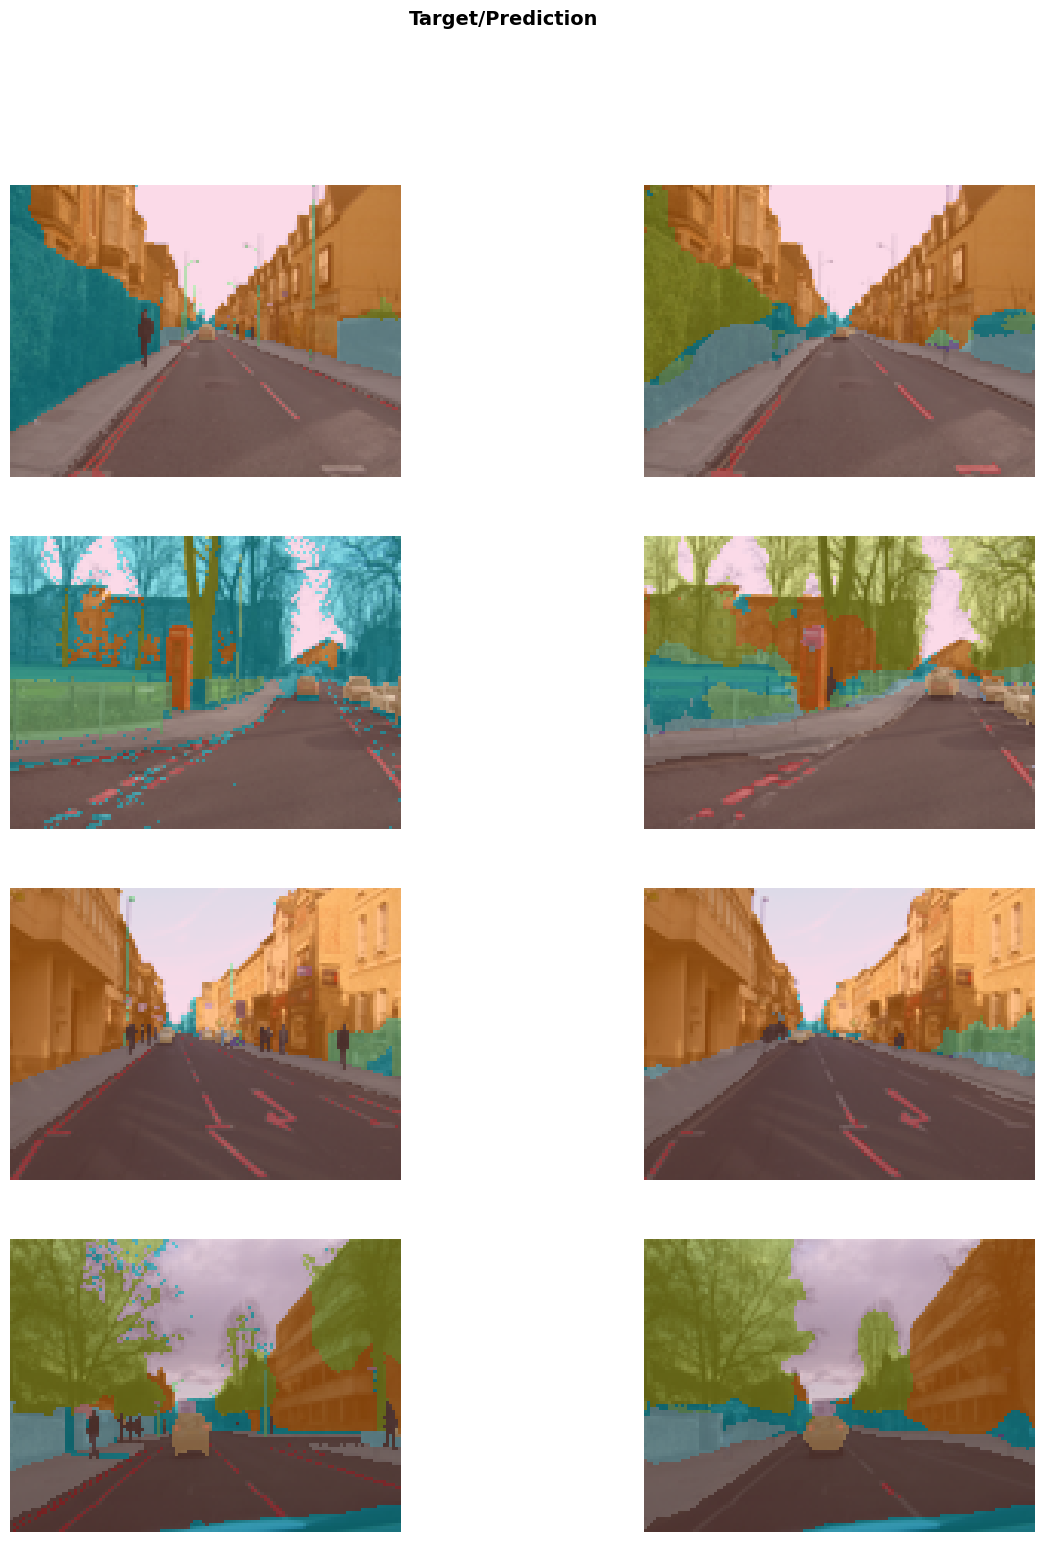

In [18]:
# Show results after 20 epochs
learn.show_results(max_n=4, figsize=(15,17.5))

### Sentiment analysis - text interpretation

In [19]:
# Import fastai text tools
from fastai.text.all import *

In [20]:
# Get image segmentation data
path = untar_data(URLs.IMDB)

In [21]:
doc(TextDataLoaders.from_folder)

In [22]:
# Create a data loader
dls = TextDataLoaders.from_folder(path,valid='test',bs=16)

In [23]:
# Create a model and train
learn = text_classifier_learner(dls,AWD_LSTM,metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.481557,0.433014,0.811440,06:25


epoch,train_loss,valid_loss,accuracy,time
0,0.321476,0.246706,0.896280,10:53
1,0.232766,0.231013,0.915520,10:52
2,0.208788,0.183636,0.929000,10:56
3,0.141798,0.189079,0.931760,10:57


In [24]:
learn.predict("I really liked that movie!")

('pos', tensor(1), tensor([0.0049, 0.9951]))

In [35]:
pred, pos, prob = learn.predict("the movie was great")
print(f'Prediction: {pred}\nProb: {prob[pos.item()]}')

Prediction: pos
Prob: 0.6894593238830566


In [37]:
pred, pos, prob = learn.predict("Even though the story was crap, I loved the movie because of all the action in it.")
print(f'Prediction: {pred}\nProb: {prob[pos.item()]}')

Prediction: pos
Prob: 0.9943813681602478


### Tabular data

In [38]:
# Import fastai required modules
from fastai.tabular.all import *

In [39]:
# Download information
path = untar_data(URLs.ADULT_SAMPLE)

In [41]:
doc(TabularDataLoaders.from_csv)

In [42]:
path

Path('C:/Users/alexb/.fastai/data/adult_sample')

In [45]:
# Create dataloaders
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, 
                                  procs=[Categorify,FillMissing,Normalize],
                                  cat_names=['workclass','education','marital-status',
                                             'occupation','relationship','race'],
                                  cont_names=['age','fnlwgt','education-num'],
                                  y_names='salary')

In [46]:
# Create model and train
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.380170,0.380372,0.826781,00:03
1,0.368157,0.365866,0.828471,00:03
2,0.353915,0.362506,0.828931,00:03


In [47]:
# Create dataloaders - reducing the number of cont_names
dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, 
                                  procs=[Categorify,FillMissing,Normalize],
                                  cat_names=['workclass','education','marital-status',
                                             'occupation','relationship','race'],
                                  cont_names=['age'],
                                  y_names='salary')

In [48]:
# Create model and train
learn = tabular_learner(dls, metrics=accuracy)
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.379960,0.361145,0.835381,00:03
1,0.369210,0.348630,0.839988,00:03
2,0.350692,0.348190,0.839834,00:03


In [102]:
test_df = pd.read_csv('~/.fastai/data/adult_sample/adult_pred.csv')
dl = learn.dls.test_dl(test_df)

In [103]:
learn.get_preds(dl=dl)

(tensor([[0.3544, 0.6456],
         [0.4527, 0.5473],
         [0.9802, 0.0198]]),
 None)

In [96]:
row, pos, probs = learn.predict(test_df.iloc[0])

In [97]:
row.show()

,workclass,education,marital-status,occupation,relationship,race,age,salary
0,Private,Bachelors,Married-civ-spouse,Exec-managerial,Husband,Other,33.0,>=50k


In [98]:
pos, probs

(tensor(1), tensor([0.3544, 0.6456]))

In [105]:
row, pos, probs = learn.predict(test_df.iloc[2])
row.show(), pos, probs

,workclass,education,marital-status,occupation,relationship,race,age,salary
0,Private,HS-grad,Divorced,#na#,Unmarried,Black,38.0,<50k


(None, tensor(0), tensor([0.9802, 0.0198]))

### Collaborative Filter

In [108]:
# Import fastai libraries
from fastai.collab import *

In [109]:
# Get data
path = untar_data(URLs.ML_SAMPLE)

In [110]:
doc(CollabDataLoaders.from_csv)

In [111]:
path

Path('C:/Users/alexb/.fastai/data/movie_lens_sample')

In [112]:
# Create dataloader
dls = CollabDataLoaders.from_csv(path/'ratings.csv')

In [113]:
# Create and train model
learn = collab_learner(dls,y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.505124,1.457668,00:00


epoch,train_loss,valid_loss,time
0,1.363464,1.397703,00:00
1,1.251538,1.214524,00:00
2,1.027482,0.898328,00:00
3,0.798208,0.743568,00:00
4,0.698259,0.699249,00:00
5,0.641592,0.685164,00:00
6,0.614679,0.678154,00:00
7,0.605944,0.674705,00:00
8,0.608208,0.673476,00:00
9,0.611595,0.673292,00:00


In [114]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,37.0,15.0,5.0,4.152184
1,56.0,88.0,5.0,4.436312
2,37.0,51.0,5.0,4.140965
3,15.0,43.0,3.5,3.747407
4,74.0,66.0,4.0,4.242622
5,19.0,66.0,4.0,4.074580
6,33.0,86.0,4.5,3.933593
7,29.0,81.0,5.0,4.253276
8,6.0,15.0,5.0,3.898620
